In [1]:
# numpy and pandas for data manipulation
import numpy as np
import pandas as pd
import sys
import networkx as nx
import os
import warnings
# matplotlib and seaborn for plotting

import matplotlib.pyplot as plt
import seaborn as sns

# sklearn preprocessing for dealing with categorical variables
from sklearn.preprocessing import LabelEncoder

import os

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
ROOT_PACKAGE_DIRECTORY = '/Users/bede01/Documents/work/phd-papers/ml-workload-optimization/code/jupyter'
ROOT_DATA_DIRECTORY = ROOT_PACKAGE_DIRECTORY + '/data'
GRAPH_DATABASE_PATH = ROOT_PACKAGE_DIRECTORY + '/data/graph/exp-reuse-same-workload.graph'
sys.path.append(ROOT_PACKAGE_DIRECTORY)

# Experiment Graph
from experiment_graph.execution_environment import ExecutionEnvironment


# Suppress warnings
warnings.filterwarnings('ignore')
% matplotlib inline


try:
    import pygraphviz
    from networkx.drawing.nx_agraph import graphviz_layout
except ImportError:
    try:
        import pydot
        from networkx.drawing.nx_pydot import graphviz_layout
    except ImportError:
        raise ImportError("This example needs Graphviz and either "
                          "PyGraphviz or pydot")

In [2]:
import os
import sys
import warnings
import hashlib

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
# Experiment Graph
from sklearn.preprocessing import LabelEncoder
from importlib import import_module


In [3]:
root_data = ROOT_PACKAGE_DIRECTORY + '/data'
DATABASE_PATH = ROOT_PACKAGE_DIRECTORY + '/data/environment_same_workload'
execution_environment = ExecutionEnvironment()

['.DS_Store', 'environment_naive', 'environment_dedup', 'home-credit-default-risk']
('Training data shape: ', (307511, 122))
('Testing data shape: ', (48744, 121))
Your selected dataframe has 122 columns.
There are 67 columns that have missing values.


,Missing Values,% of Total Values
COMMONAREA_MEDI,214865,69.9
COMMONAREA_AVG,214865,69.9
COMMONAREA_MODE,214865,69.9
NONLIVINGAPARTMENTS_MEDI,213514,69.4
NONLIVINGAPARTMENTS_MODE,213514,69.4
NONLIVINGAPARTMENTS_AVG,213514,69.4
FONDKAPREMONT_MODE,210295,68.4
LIVINGAPARTMENTS_MODE,210199,68.4
LIVINGAPARTMENTS_MEDI,210199,68.4
LIVINGAPARTMENTS_AVG,210199,68.4


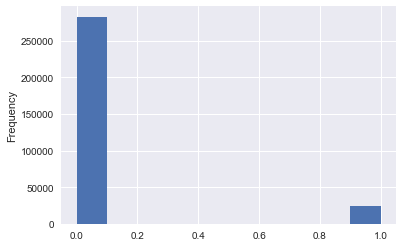

In [4]:
print(os.listdir(root_data))
app_train = execution_environment.load(root_data + '/home-credit-default-risk/application_train.csv')
print('Training data shape: ', app_train.shape().data())
app_train.head().data()

app_test = execution_environment.load(root_data + '/home-credit-default-risk/application_test.csv')
print('Testing data shape: ', app_test.shape().data())
app_test.head().data()

app_train['TARGET'].value_counts().data()

app_train['TARGET'].data().astype(int).plot.hist()

# Function to calculate missing values by column# Funct
def missing_values_table(dataset):
    # Total missing values
    mis_val = dataset.isnull().sum().data()

    mis_val_percent = 100 * mis_val / len(dataset.data())

    # Make a table with the results
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    # Rename the columns
    mis_val_table_ren_columns = mis_val_table.rename(columns={
        0: 'Missing Values',
        1: '% of Total Values'
    })
    # Sort the table by percentage of missing descending
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:, 1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)

    # Print some summary information
    print("Your selected dataframe has " + str(dataset.shape().data()[1]) + " columns.\n"
                                                                            "There are " + str(
        mis_val_table_ren_columns.shape[0]) +
          " columns that have missing values.")

    # Return the dataframe with missing information
    return mis_val_table_ren_columns

missing_values = missing_values_table(app_train)
missing_values.head(20)

In [5]:
app_train.dtypes().data().value_counts()

app_train.select_dtypes('object').nunique().data()

# Create a label encoder object
le = LabelEncoder()
le_count = 0

for col in app_train.select_dtypes('object').data().columns:
    # we are not using nunique because it discard nan
    if app_train[col].nunique(dropna=False).data() <= 2:
        model = app_train[col].fit_sk_model(le)

        transformed_train = model.transform_col(app_train[col], col)
        app_train = app_train.drop(col)
        app_train = app_train.add_columns(col, transformed_train)

        transformed_test = model.transform_col(app_test[col], col)
        app_test = app_test.drop(col)
        app_test = app_test.add_columns(col, transformed_test)

        # Keep track of how many columns were label encoded
        le_count += 1
print('%d columns were label encoded.' % le_count)

3 columns were label encoded.


In [11]:
#execution_environment.graph.plot_graph(plt)
for e in execution_environment.graph.graph.edges(data=True):
    print e[2]['name'],e[2]['execution_time']

combine 0.0
nunique 21.213
transform_col 35.483
transform_col 5.685
sum 685.38
nunique 31.496
transform_col 34.492
transform_col 36.587
project 790.832
drop 991.238
drop 187.936
project 103.521
combine 0.0
fit_sk_model 9.099
nunique 9.51
combine 0.0
nunique 10.187
nunique 27.96
add_columns 994.048
combine 0.0
add_columns 151.641
project 708.015
project 778.081
drop 949.761
nunique 27.45
nunique 17.592
nunique 33.465
combine 0.0
combine 0.0
combine 0.0
combine 0.0
fit_sk_model 12.445
nunique 14.035
add_columns 187.199
combine 0.0
value_counts 5.453
combine 0.0
combine 0.0
combine 0.0
project 721.319
project 724.316
project 734.357
project 712.86
project 733.929
project 744.965
project 732.315
project 776.558
project 727.31
project 723.139
project 728.047
project 715.844
add_columns 962.097
nunique 16.047
nunique 20.054
select_dtypes 810.322
shape 789.223
project 777.441
drop 2.639
head 702.19
dtypes 770.975
isnull 50.279
project 741.638
combine 0.0
combine 0.0
drop 160.217
shape 105.487

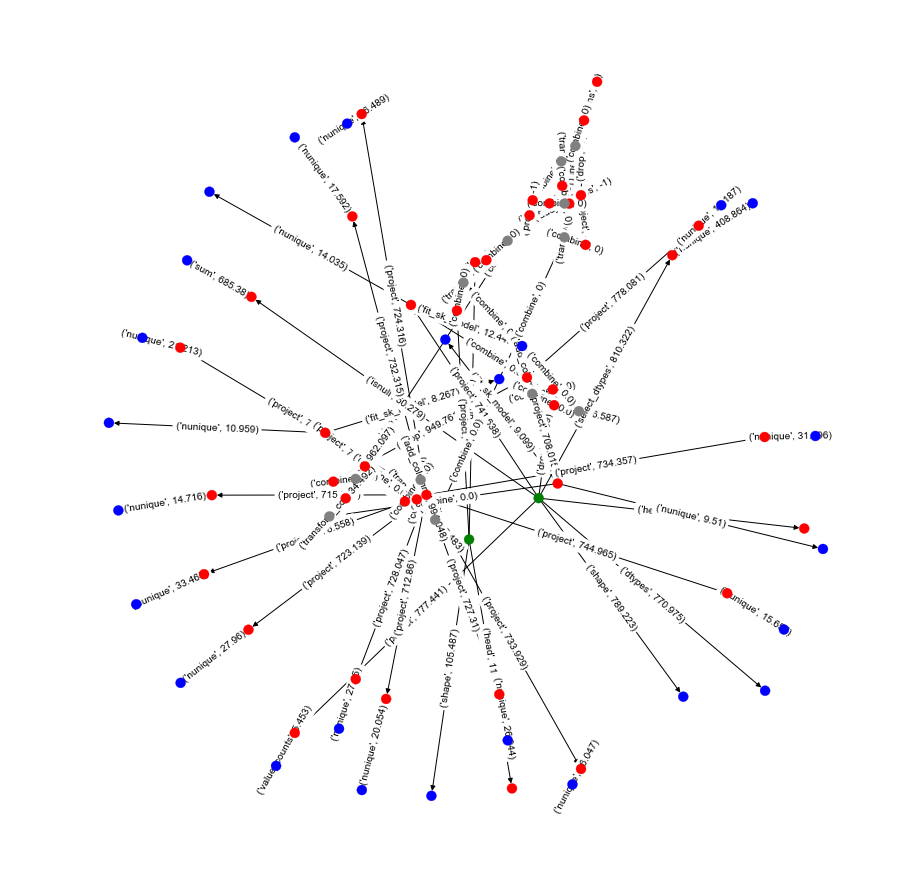

In [6]:
execution_environment.graph.plot_graph(plt)

In [7]:


train = train.replace_columns('previous_loan_counts', train['previous_loan_counts'].fillna(0))
train.head().data()

# Plots the distribution of a variable colored by value of the target
def kde_target(var_name, df):
    # Calculate the correlation coefficient between the new variable and the target
    corr = df['TARGET'].corr(df[var_name])

    # Calculate medians for repaid vs not repaid
    avg_repaid = df[df['TARGET'] == 0][var_name].median()
    avg_not_repaid = df[df['TARGET'] == 1][var_name].median()

    plt.figure(figsize=(12, 6))

    # Plot the distribution for target == 0 and target == 1
    sns.kdeplot(df[df['TARGET'] == 0][var_name].dropna().data(), label='TARGET == 0')
    sns.kdeplot(df[df['TARGET'] == 1][var_name].dropna().data(), label='TARGET == 1')

    # label the plot
    plt.xlabel(var_name)
    plt.ylabel('Density')
    plt.title('%s Distribution' % var_name)
    plt.legend()

    # print out the correlation
    print('The correlation between %s and the TARGET is %0.4f' % (var_name, corr.data()))
    # Print out average values
    print('Median value for loan that was not repaid = %0.4f' % avg_not_repaid.data())
    print('Median value for loan that was repaid =     %0.4f' % avg_repaid.data())

NameError: name 'train' is not defined

In [ ]:
kde_target('EXT_SOURCE_3', train)

In [ ]:
train['previous_loan_counts'].data()

In [ ]:
train.head().data()

In [ ]:
train = train.replace_columns('previous_loan_counts', train['previous_loan_counts'].fillna(0))

In [ ]:
# Function to calculate missing values by column# Funct
def missing_values_table(dataset):
    # Total missing values
    mis_val = dataset.isnull().sum().data()

    mis_val_percent = 100 * mis_val / len(dataset.data())

    # Make a table with the results
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    # Rename the columns
    mis_val_table_ren_columns = mis_val_table.rename(columns={
        0: 'Missing Values',
        1: '% of Total Values'
    })
    # Sort the table by percentage of missing descending
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:, 1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)

    # Print some summary information
    print("Your selected dataframe has " + str(dataset.shape().data()[1]) + " columns.\n"
                                                                          "There are " + str(
        mis_val_table_ren_columns.shape[0]) +
          " columns that have missing values.")

    # Return the dataframe with missing information
    return mis_val_table_ren_columns


missing_values = missing_values_table(app_train)
missing_values.head(20)

In [ ]:
app_train.dtypes().data().value_counts()

In [ ]:
app_train.select_dtypes('object').nunique().data()

In [ ]:
le = LabelEncoder()
le_count = 0

columns = app_train.select_dtypes('object').data().columns
for col in columns:
    # we are not using nunique because it discard nan
    if app_train[col].nunique(dropna=False).data() <= 2:
        model = app_train[col].fit_sk_model(le)

        transformed_train = model.transform_col(app_train[col], col)
        app_train = app_train.drop(col)
        app_train = app_train.add_columns(col, transformed_train)

        transformed_test = model.transform_col(app_test[col], col)
        app_test = app_test.drop(col)
        app_test = app_test.add_columns(col, transformed_test)

        # Keep track of how many columns were label encoded
        le_count += 1
print('%d columns were label encoded.' % le_count)

In [ ]:
app_train = app_train.onehot_encode()
app_test = app_test.onehot_encode()

print('Training Features shape: ', app_train.shape().data())
print('Testing Features shape: ', app_test.shape().data())

In [ ]:
train_labels = app_train['TARGET']
train_columns = app_train.data().columns
test_columns = app_test.data().columns
for c in train_columns:
    if c not in test_columns:
        app_train = app_train.drop(c)

app_train = app_train.add_columns('TARGET', train_labels)

In [ ]:
print('Training Features shape: ', app_train.shape().data())
print('Testing Features shape: ', app_test.shape().data())

In [ ]:
(app_train['DAYS_BIRTH'] / 365).describe().data()

app_train['DAYS_EMPLOYED'].describe().data()

app_train['DAYS_EMPLOYED'].data().plot.hist(title='Days Employment Histogram')
plt.xlabel('Days Employment')

In [ ]:
anom = app_train[app_train['DAYS_EMPLOYED'] == 365243]
non_anom = app_train[app_train['DAYS_EMPLOYED'] != 365243]
print('The non-anomalies default on %0.2f%% of loans' % (100 * non_anom['TARGET'].mean().data()))
print('The anomalies default on %0.2f%% of loans' % (100 * anom['TARGET'].mean().data()))
print('There are %d anomalous days of employment' % anom.shape().data()[0])

In [ ]:
days_employed_anom = app_train['DAYS_EMPLOYED'] == 365243
app_train = app_train.add_columns('DAYS_EMPLOYED_ANOM', days_employed_anom)
temp = app_train['DAYS_EMPLOYED'].replace({365243: np.nan})
app_train = app_train.drop('DAYS_EMPLOYED')
app_train = app_train.add_columns('DAYS_EMPLOYED', temp)

In [ ]:
app_train["DAYS_EMPLOYED"].data().plot.hist(title='Days Employment Histogram');
plt.xlabel('Days Employment')

In [ ]:
days_employed_anom = app_test["DAYS_EMPLOYED"] == 365243
app_test = app_test.add_columns('DAYS_EMPLOYED_ANOM', days_employed_anom)
temp = app_test['DAYS_EMPLOYED'].replace({365243: np.nan})
app_test = app_test.drop('DAYS_EMPLOYED')
app_test = app_test.add_columns('DAYS_EMPLOYED', temp)
print('There are %d anomalies in the test data out of %d entries'
      % (app_test['DAYS_EMPLOYED_ANOM'].sum().data(),
         app_test.shape().data()[0]))

In [ ]:
# correlations = app_train.corr().data()
# top = correlations['TARGET'].sort_values()
# # Display correlations
# print('Most Positive Correlations:\n', top.tail(15))
# print('\nMost Negative Correlations:\n', top.head(15))

In [ ]:
abs_age = app_train['DAYS_BIRTH'].abs()
app_train = app_train.drop('DAYS_BIRTH')
app_train = app_train.add_columns('DAYS_BIRTH', abs_age)
app_train['DAYS_BIRTH'].corr(app_train['TARGET']).data()

In [ ]:
# Set the style of plots
plt.style.use('fivethirtyeight')

# Plot the distribution of ages in years
plt.hist((app_train['DAYS_BIRTH'] / 365).data(), edgecolor='k', bins=25)
plt.title('Age of Client')
plt.xlabel('Age (years)')
plt.ylabel('Count')

In [ ]:
# plt.figure(figsize=(10, 8))
# # KDE plot of loans that were repaid on time
# sns.kdeplot((app_train[app_train['TARGET'] == 0]['DAYS_BIRTH'] / 365).data(), label='target == 0')
# # KDE plot of loans which were not repaid on time
# sns.kdeplot((app_train[app_train['TARGET'] == 1]['DAYS_BIRTH'] / 365).data(), label='target == 1')
# # Labeling of plot
# plt.xlabel('Age (years)')
# plt.ylabel('Density')
# plt.title('Distribution of Ages')

In [ ]:
# Age information into a separate dataframe
age_data = app_train[['TARGET', 'DAYS_BIRTH']]
years_birth = age_data['DAYS_BIRTH'] / 365
age_data = age_data.add_columns('YEARS_BIRTH', years_birth)
binned = age_data['YEARS_BIRTH'].binning(20, 70, 11)
binned.setname('YEARS_BINNED')
age_data = age_data.add_columns('YEARS_BINNED', binned)
age_data.head(10).data()

age_groups = age_data.groupby('YEARS_BINNED').mean()

In [ ]:
plt.figure(figsize=(8, 8))

# Graph the age bins and the average of the target as a bar plot
plt.bar(age_groups.data().index.astype(str), age_groups.data()['TARGET'] * 100)

# Plot labeling
plt.xticks(rotation=75)
plt.xlabel('Age Group (years)')
plt.ylabel('Failure to Repay (%)')
plt.title('Failure to Repay by Age Group')

In [ ]:
# ext_data = app_train[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]
# ext_data_corrs = ext_data.corr().data()

# plt.figure(figsize=(8, 6))

# # Heatmap of correlations
# sns.heatmap(ext_data_corrs, cmap=plt.cm.RdYlBu_r, vmin=-0.25, annot=True, vmax=0.6)
# plt.title('Correlation Heatmap')

In [ ]:
# plt.figure(figsize=(10, 12))

# # iterate through the sources
# for i, column in enumerate(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']):
#     # create a new subplot for each source
#     plt.subplot(3, 1, i + 1)
#     # plot repaid loans
#     source_data = app_train[[column, 'TARGET']][app_train['TARGET'] == 0]
#     sns.kdeplot(source_data[app_train[column].notna()][column].data(), label='target == 0')
#     # plot loans that were not repaid
#     source_data = app_train[[column, 'TARGET']][app_train['TARGET'] == 1]
#     sns.kdeplot(source_data[app_train[column].notna()][column].data(), label='target == 1')

#     # Label the plots
#     plt.title('Distribution of %s by Target Value' % column)
#     plt.xlabel('%s' % column)
#     plt.ylabel('Density')

# plt.tight_layout(h_pad=2.5)

In [ ]:
# # Copy the data for plotting
# plot_data = ext_data.drop('DAYS_BIRTH')

# # Add in the age of the client in years
# plot_data = plot_data.add_columns('YEARS_BIRTH', age_data['YEARS_BIRTH'])
# # Drop na values and limit to first 100000 rows
# plot_data = plot_data.head(100000).dropna()

# # Create the pair grid object
# grid = sns.PairGrid(data=plot_data.data(), size=3, diag_sharey=False,
#                     hue='TARGET',
#                     vars=[x for x in list(plot_data.data().columns) if x != 'TARGET'])

# # Upper is a scatter plot
# grid.map_upper(plt.scatter, alpha=0.2)

# # Diagonal is a histogram
# grid.map_diag(sns.kdeplot)

# # Bottom is density plot
# grid.map_lower(sns.kdeplot, cmap=plt.cm.OrRd_r)

# plt.suptitle('Ext Source and Age Features Pairs Plot', size=32, y=1.05)

In [ ]:
# Make a new dataframe for polynomial features
poly_features = app_train[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH', 'TARGET']]
poly_features_test = app_test[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]

# imputer for handling missing values
from sklearn.preprocessing import Imputer

imputer = Imputer(strategy='median')

poly_target = poly_features['TARGET']

poly_features = poly_features.drop(columns=['TARGET'])

# Need to impute missing values
imputer_model = poly_features.fit_sk_model(imputer)
poly_features = imputer_model.transform(poly_features)
poly_features_test = imputer_model.transform(poly_features_test)

from sklearn.preprocessing import PolynomialFeatures

# Create the polynomial object with specified degree
poly_transformer = PolynomialFeatures(degree=3)

# Train the polynomial features
poly_transformer_model = poly_features.fit_sk_model(poly_transformer)

poly_features = poly_transformer_model.transform(poly_features)
poly_features_test = poly_transformer_model.transform(poly_features_test)

new_names = poly_transformer_model.data().get_feature_names(input_features=[
    'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH'
])

# Call manually before meta data update
poly_features.set_columns(new_names)

In [ ]:
# Add in the target
poly_features = poly_features.add_columns('TARGET', poly_target)

# Find the correlations with the target
poly_corrs = poly_features.corr().data()['TARGET'].sort_values()

# Display most negative and most positive
print(poly_corrs.head(10))
print(poly_corrs.tail(5))
poly_features_test.set_columns(new_names)

In [ ]:
# Merge polynomial features into training dataframe
poly_features = poly_features.add_columns('SK_ID_CURR', app_train['SK_ID_CURR'])
app_train_poly = app_train.merge(poly_features, on='SK_ID_CURR', how='left')

In [ ]:
# Merge polnomial features into testing dataframe
poly_features_test = poly_features_test.add_columns('SK_ID_CURR', app_test['SK_ID_CURR'])
app_test_poly = app_test.merge(poly_features_test, on='SK_ID_CURR', how='left')

In [ ]:
# Align the dataframes
train_columns = app_train_poly.data().columns
test_columns = app_test_poly.data().columns
for c in train_columns:
    if c not in test_columns:
        app_train_poly = app_train_poly.drop(c)

In [ ]:
# Print out the new shapes
print('Training data with polynomial features shape: ',
      app_train_poly.shape().data())
print('Testing data with polynomial features shape:  ',
      app_test_poly.shape().data())

In [ ]:
app_train_domain = app_train.copy()
app_test_domain = app_test.copy()

app_train_domain = app_train_domain.add_columns(
    'CREDIT_INCOME_PERCENT',
    app_train_domain['AMT_CREDIT'] / app_train_domain['AMT_INCOME_TOTAL'])
app_train_domain = app_train_domain.add_columns(
    'ANNUITY_INCOME_PERCENT',
    app_train_domain['AMT_ANNUITY'] / app_train_domain['AMT_INCOME_TOTAL'])
app_train_domain = app_train_domain.add_columns(
    'CREDIT_TERM',
    app_train_domain['AMT_ANNUITY'] / app_train_domain['AMT_CREDIT'])
app_train_domain = app_train_domain.add_columns(
    'DAYS_EMPLOYED_PERCENT',
    app_train_domain['DAYS_EMPLOYED'] / app_train_domain['DAYS_BIRTH'])

app_test_domain = app_test_domain.add_columns(
    'CREDIT_INCOME_PERCENT',
    app_test_domain['AMT_CREDIT'] / app_test_domain['AMT_INCOME_TOTAL'])
app_test_domain = app_test_domain.add_columns(
    'ANNUITY_INCOME_PERCENT',
    app_test_domain['AMT_ANNUITY'] / app_test_domain['AMT_INCOME_TOTAL'])
app_test_domain = app_test_domain.add_columns(
    'CREDIT_TERM',
    app_test_domain['AMT_ANNUITY'] / app_test_domain['AMT_CREDIT'])
app_test_domain = app_test_domain.add_columns(
    'DAYS_EMPLOYED_PERCENT',
    app_test_domain['DAYS_EMPLOYED'] / app_test_domain['DAYS_BIRTH'])

In [ ]:
# plt.figure(figsize=(12, 20))
# # iterate through the new features
# for i, column in enumerate([
#     'CREDIT_INCOME_PERCENT', 'ANNUITY_INCOME_PERCENT', 'CREDIT_TERM',
#     'DAYS_EMPLOYED_PERCENT'
# ]):
#     # create a new subplot for each source
#     plt.subplot(4, 1, i + 1)
#     # plot repaid loans
#     negative = app_train_domain[[column, 'TARGET']][app_train['TARGET'] == 0]
#     sns.kdeplot(
#         negative[app_train_domain[column].notna()][column].data(),
#         label='target == 0')
#     # plot loans that were not repaid
#     positive = app_train_domain[[column, 'TARGET']][app_train['TARGET'] == 1]
#     sns.kdeplot(
#         positive[app_train_domain[column].notna()][column].data(),
#         label='target == 1')

#     # Label the plots
#     plt.title('Distribution of %s by Target Value' % column)
#     plt.xlabel('%s' % column)
#     plt.ylabel('Density')

# plt.tight_layout(h_pad=2.5)

In [ ]:
from sklearn.preprocessing import MinMaxScaler, Imputer

# Drop the target from the training data
columns = app_train.data().columns
if 'TARGET' in columns:
    train = app_train.drop(columns=['TARGET'])
else:
    train = app_train.copy()


# Feature names
features = list(train.data().columns)

# Copy of the testing data
test = app_test.copy()

# Median imputation of missing values
sk_imputer = Imputer(strategy='median')

# Scale each feature to 0-1
sk_scaler = MinMaxScaler(feature_range=(0, 1))

# Fit on the training data
imputer = train.fit_sk_model(sk_imputer)

# Transform both training and testing data
train = imputer.transform(train)
test = imputer.transform(test)

# Repeat with the scaler
scaler = train.fit_sk_model(sk_scaler)
train = scaler.transform(train)
test = scaler.transform(test)

print('Training data shape: ', train.shape().data())
print('Testing data shape: ', test.shape().data())

In [ ]:
from sklearn.linear_model import LogisticRegression

# Make the model with the specified regularization parameter
sk_log_reg = LogisticRegression(C=0.0001)

# Train on the training data
log_reg = train.fit_sk_model_with_labels(sk_log_reg, train_labels)

# Make predictions
# Make sure to select the second column only
log_reg_pred = log_reg.predict_proba(test)[1]

# Submission data
log_reg_pred.setname('TARGET')
submit = app_test['SK_ID_CURR'].concat(log_reg_pred)
submit.head().data()

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Make the random forest classifier
sk_random_forest = RandomForestClassifier(n_estimators=5, random_state=50, verbose=1, n_jobs=-1)

# Train on the training data
random_forest = train.fit_sk_model_with_labels(sk_random_forest, train_labels)

# Extract feature importances
feature_importances = random_forest.feature_importances(features)

# Make predictions on the test data
predictions = random_forest.predict_proba(test)[1]

# Score = 0.678
# Submission dataframe
predictions.setname('TARGET')
submit = app_test['SK_ID_CURR'].concat(predictions)
submit.head().data()

In [ ]:
# poly_features_names = list(app_train_poly.data().columns)

# # Impute the polynomial features
# sk_imputer = Imputer(strategy='median')
# imputer = app_train_poly.fit_sk_model(sk_imputer)

# poly_features = imputer.transform(app_train_poly)
# poly_features_test = imputer.transform(app_test_poly)

# # Scale the polynomial features
# sk_scaler = MinMaxScaler(feature_range=(0, 1))
# scaler = poly_features.fit_sk_model(sk_scaler)

# poly_features = scaler.transform(poly_features)
# poly_features_test = scaler.transform(poly_features_test)

# sk_random_forest_poly = RandomForestClassifier(n_estimators=100, random_state=50, verbose=1, n_jobs=-1)
# random_forest_poly = poly_features.fit_sk_model_with_labels(sk_random_forest_poly, train_labels)

# # Make predictions on the test data
# predictions = random_forest_poly.predict_proba(poly_features_test)[1]

# # Score = 0.678
# # Submission dataframe
# predictions.setname('TARGET')
# submit = app_test['SK_ID_CURR'].concat(predictions)
# submit.head().data()

In [ ]:
# app_train_domain = app_train_domain.drop(columns='TARGET')

# domain_features_names = list(app_train_domain.data().columns)

# # Impute the domainnomial features
# sk_imputer = Imputer(strategy='median')
# imputer = app_train_domain.fit_sk_model(sk_imputer)

# domain_features = imputer.transform(app_train_domain)
# domain_features_test = imputer.transform(app_test_domain)

# # Scale the domainnomial features
# sk_scaler = MinMaxScaler(feature_range=(0, 1))
# scaler = domain_features.fit_sk_model(sk_scaler)

# domain_features = scaler.transform(domain_features)
# domain_features_test = scaler.transform(domain_features_test)

# # Train on the training data
# sk_random_forest_domain = RandomForestClassifier(n_estimators=100, random_state=50, verbose=1, n_jobs=-1)
# random_forest_domain = domain_features.fit_sk_model_with_labels(sk_random_forest_domain, train_labels)

# # Extract feature importances
# feature_importances_domain = random_forest_domain.feature_importances(domain_features_names)

# # Make predictions on the test data
# predictions = random_forest_domain.predict_proba(domain_features_test)[1]

# # Score = 0.678
# # Make a submission dataframe
# predictions.setname('TARGET')
# submit = app_test['SK_ID_CURR'].concat(predictions)
# submit.head().data()

In [ ]:
def plot_feature_importances(df):
    """
    Plot importances returned by a model. This can work with any measure of
    feature importance provided that higher importance is better.

    Args:
        df (dataframe): feature importances. Must have the features in a column
        called `features` and the importances in a column called `importance

    Returns:
        shows a plot of the 15 most importance features

        df (dataframe): feature importances sorted by importance (highest to lowest)
        with a column for normalized importance
        """

    # Sort features according to importance
    df = df.sort_values('importance', ascending=False)

    # Normalize the feature importances to add up to one
    df = df.add_columns('importance_normalized', df['importance'] / df['importance'].sum().data())

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize=(10, 6))
    ax = plt.subplot()

    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.data().index[:15]))),
            df['importance_normalized'].data().head(15),
            align='center', edgecolor='k')

    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.data().index[:15]))))
    ax.set_yticklabels(df['feature'].data().head(15))

    # Plot labeling
    plt.xlabel('Normalized Importance');
    plt.title('Feature Importances')
    plt.show()

    return df


# Show the feature importances for the default features
feature_importances_sorted = plot_feature_importances(feature_importances)

feature_importances_domain_sorted = plot_feature_importances(feature_importances_domain)